# 异常检测（Anomaly Detection）完整教程

## 📚 什么是异常检测？

异常检测是机器学习中的一个重要任务，旨在识别数据集中与大多数数据显著不同的异常点或离群点。

### 核心概念：
- **异常点（Anomaly/Outlier）**：与正常模式显著偏离的数据点
- **正常点（Normal/Inlier）**：符合预期模式的数据点
- **检测阈值（Threshold）**：区分正常与异常的边界值

### 异常类型：
1. **点异常**：单个数据点的异常（如异常高额交易）
2. **上下文异常**：在特定上下文中的异常（如夏天的低温）
3. **集体异常**：一组数据点共同构成的异常（如心电图异常模式）

# 导入必要的库
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

def generate_sample_data(n_samples=1000):
    """
    生成模拟的信用卡交易数据
    
    参数:
    n_samples: 生成的样本数量，默认1000个
    
    返回:
    normal_amounts: 交易金额数组（包含正常和异常交易）
    times: 交易时间列表
    
    数据生成策略:
    - 98%的正常交易：金额在100-1000元之间，符合正态分布
    - 2%的异常交易：金额在2000-5000元之间，模拟欺诈或异常高额消费
    """
    # 步骤1: 生成正常交易数据
    # 使用正态分布生成，均值500，标准差200
    normal_amounts = np.random.normal(500, 200, n_samples)
    
    # 步骤2: 使用clip函数限制金额范围在100-1000之间
    # 这模拟了日常消费的合理范围
    normal_amounts = np.clip(normal_amounts, 100, 1000)
    
    # 步骤3: 添加异常值（模拟欺诈交易）
    # 随机选择2%的数据点作为异常
    anomaly_indices = np.random.choice(
        n_samples, 
        size=int(n_samples * 0.02),  # 2%的异常率
        replace=False  # 不重复选择
    )
    
    # 将选中的点设置为异常高额交易（2000-5000元）
    normal_amounts[anomaly_indices] = np.random.uniform(
        2000, 5000, 
        size=len(anomaly_indices)
    )
    
    # 步骤4: 生成时间序列数据
    # 假设每30分钟一笔交易
    base_time = datetime.now()
    times = [base_time + timedelta(minutes=i*30) for i in range(n_samples)]
    
    return normal_amounts, times

def statistical_anomaly_detection(data, threshold=3):
    """
    使用统计方法（Z-score）进行异常检测
    
    原理:
    Z-score = |x - μ| / σ
    其中 μ是均值，σ是标准差
    
    参数:
    data: 输入数据数组
    threshold: Z-score阈值，默认为3（3-sigma规则）
              - 1σ: 包含68.27%的数据
              - 2σ: 包含95.45%的数据
              - 3σ: 包含99.73%的数据
    
    返回:
    异常值的索引数组
    """
    # 步骤1: 计算数据的均值和标准差
    mean = np.mean(data)
    std = np.std(data)
    
    # 步骤2: 计算每个数据点的Z-score
    # 使用绝对值因为我们关心的是偏离程度，不管方向
    z_scores = np.abs((data - mean) / std)
    
    # 步骤3: 找出Z-score超过阈值的点
    # 这些点被认为是统计上的异常值
    anomaly_indices = np.where(z_scores > threshold)[0]
    
    # 打印一些统计信息（用于调试和理解）
    print(f"数据均值: {mean:.2f}")
    print(f"数据标准差: {std:.2f}")
    print(f"异常阈值 (均值 ± {threshold}σ): [{mean-threshold*std:.2f}, {mean+threshold*std:.2f}]")
    
    return anomaly_indices

def ml_anomaly_detection(data):
    """
    使用隔离森林（Isolation Forest）进行异常检测
    
    算法原理:
    1. 随机选择特征和分割值构建多棵隔离树
    2. 异常点更容易被隔离（需要更少的分割次数）
    3. 正常点需要更多分割才能被隔离
    4. 通过平均路径长度判断异常程度
    
    参数:
    data: 输入数据数组
    
    返回:
    异常值的索引数组
    """
    # 步骤1: 数据预处理
    # 隔离森林需要二维输入，将一维数组重塑为二维
    X = data.reshape(-1, 1)
    
    # 步骤2: 创建隔离森林模型
    clf = IsolationForest(
        contamination=0.05,  # 预期的异常比例（5%）
        random_state=42,      # 随机种子，保证结果可重现
        n_estimators=100,     # 森林中树的数量
        max_samples='auto',   # 每棵树的样本数
        bootstrap=False       # 不使用bootstrap采样
    )
    
    # 步骤3: 训练模型
    clf.fit(X)
    
    # 步骤4: 预测异常
    # 返回值: 1表示正常，-1表示异常
    predictions = clf.predict(X)
    
    # 步骤5: 获取异常分数（可选，用于调试）
    anomaly_scores = clf.score_samples(X)
    
    # 步骤6: 找出预测为异常的点的索引
    anomaly_indices = np.where(predictions == -1)[0]
    
    # 打印模型信息
    print(f"隔离森林检测阈值: {clf.offset_:.4f}")
    print(f"平均异常分数: {np.mean(anomaly_scores):.4f}")
    
    return anomaly_indices

def visualize_results(amounts, times, statistical_anomalies, ml_anomalies):
    """
    可视化异常检测结果，对比不同方法的效果
    
    参数:
    amounts: 交易金额数组
    times: 交易时间列表
    statistical_anomalies: 统计方法检测到的异常索引
    ml_anomalies: 机器学习方法检测到的异常索引
    
    返回:
    matplotlib的figure对象
    """
    # 创建图形，设置大小
    plt.figure(figsize=(15, 8))
    
    # 主图：时间序列图
    plt.subplot(2, 1, 1)
    
    # 绘制所有正常交易（蓝色点）
    plt.scatter(times, amounts, c='blue', alpha=0.5, 
                label=f'正常交易 (n={len(amounts)})', s=20)
    
    # 用红色X标记统计方法检测到的异常
    if len(statistical_anomalies) > 0:
        plt.scatter(np.array(times)[statistical_anomalies], 
                   amounts[statistical_anomalies], 
                   c='red', marker='x', s=100, 
                   label=f'统计方法异常 (n={len(statistical_anomalies)})')
    
    # 用绿色圆圈标记机器学习方法检测到的异常
    if len(ml_anomalies) > 0:
        plt.scatter(np.array(times)[ml_anomalies], 
                   amounts[ml_anomalies], 
                   c='green', marker='o', s=100, facecolors='none',
                   edgecolors='green', linewidths=2,
                   label=f'ML方法异常 (n={len(ml_anomalies)})')
    
    plt.title('信用卡交易异常检测结果对比', fontsize=14, fontweight='bold')
    plt.xlabel('交易时间')
    plt.ylabel('交易金额（元）')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    
    # 子图：金额分布直方图
    plt.subplot(2, 1, 2)
    
    # 绘制金额分布直方图
    n, bins, patches = plt.hist(amounts, bins=50, alpha=0.7, 
                                color='blue', edgecolor='black')
    
    # 标记异常区域
    plt.axvline(x=1500, color='red', linestyle='--', 
                label='异常阈值参考线', alpha=0.7)
    
    plt.title('交易金额分布图', fontsize=12)
    plt.xlabel('交易金额（元）')
    plt.ylabel('频次')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return plt

# ========== 主程序执行部分 ==========
if __name__ == "__main__":
    print("="*50)
    print("信用卡交易异常检测演示")
    print("="*50)
    
    # 步骤1: 生成模拟数据
    print("\n1. 生成模拟交易数据...")
    amounts, times = generate_sample_data(n_samples=1000)
    print(f"   生成了 {len(amounts)} 笔交易数据")
    print(f"   金额范围: {amounts.min():.2f} - {amounts.max():.2f} 元")
    
    # 步骤2: 统计方法检测
    print("\n2. 使用统计方法（Z-score）检测异常...")
    statistical_anomalies = statistical_anomaly_detection(amounts, threshold=3)
    print(f"   检测到 {len(statistical_anomalies)} 个异常交易")
    
    # 步骤3: 机器学习方法检测
    print("\n3. 使用机器学习方法（Isolation Forest）检测异常...")
    ml_anomalies = ml_anomaly_detection(amounts)
    print(f"   检测到 {len(ml_anomalies)} 个异常交易")
    
    # 步骤4: 计算两种方法的重叠
    overlap = set(statistical_anomalies) & set(ml_anomalies)
    print(f"\n4. 两种方法都检测到的异常: {len(overlap)} 个")
    
    # 步骤5: 可视化结果
    print("\n5. 生成可视化图表...")
    plt_obj = visualize_results(amounts, times, statistical_anomalies, ml_anomalies)
    plt_obj.show()
    
    print("\n" + "="*50)
    print("异常检测完成！")

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ========== 深度学习异常检测示例 ==========

def generate_data(n_samples=1000):
    """
    生成用于二分类的示例数据
    
    参数:
    n_samples: 样本数量
    
    返回:
    X: 特征矩阵 (n_samples, 20)
    y: 标签向量 (n_samples,)，0表示正常，1表示异常
    
    数据生成逻辑:
    - 20个特征，前5个特征与标签相关
    - 如果前5个特征的和>0，则为异常（标签=1）
    """
    np.random.seed(42)  # 固定随机种子，保证结果可重现
    
    # 生成20维的随机特征，服从标准正态分布
    X = np.random.normal(0, 1, (n_samples, 20))
    
    # 基于前5个特征生成标签
    # 这模拟了只有部分特征与异常相关的真实场景
    y = (np.sum(X[:, :5], axis=1) > 0).astype(int)
    
    # 添加一些噪声，使问题更具挑战性
    noise_indices = np.random.choice(n_samples, size=int(n_samples * 0.05), replace=False)
    y[noise_indices] = 1 - y[noise_indices]  # 翻转5%的标签
    
    return X, y

def create_model(input_shape):
    """
    创建用于异常检测的神经网络模型
    
    参数:
    input_shape: 输入特征的形状
    
    返回:
    编译好的Keras模型
    
    网络架构:
    Input(20) → Dense(64) → Dropout(0.2) → Dense(32) → Dropout(0.2) → Dense(1)
    """
    model = tf.keras.Sequential([
        # 第一层：64个神经元，ReLU激活
        # ReLU: f(x) = max(0, x)，解决梯度消失问题
        tf.keras.layers.Dense(
            64, 
            activation='relu', 
            input_shape=input_shape,
            kernel_initializer='he_normal'  # He初始化，适合ReLU
        ),
        
        # Dropout层：随机丢弃20%的连接，防止过拟合
        tf.keras.layers.Dropout(0.2),
        
        # 第二层：32个神经元，继续降维
        tf.keras.layers.Dense(
            32, 
            activation='relu',
            kernel_initializer='he_normal'
        ),
        
        # 第二个Dropout层
        tf.keras.layers.Dropout(0.2),
        
        # 输出层：1个神经元，Sigmoid激活用于二分类
        # Sigmoid: f(x) = 1 / (1 + e^(-x))，输出范围[0, 1]
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    # 编译模型
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Adam优化器
        loss='binary_crossentropy',  # 二分类交叉熵损失
        metrics=['accuracy', 
                 tf.keras.metrics.Precision(name='precision'),  # 精确率
                 tf.keras.metrics.Recall(name='recall')]        # 召回率
    )
    
    # 打印模型结构
    print("模型架构：")
    model.summary()
    
    return model

def plot_training_history(history):
    """
    绘制训练历史，包括损失和准确率曲线
    
    参数:
    history: model.fit()返回的历史对象
    """
    plt.figure(figsize=(15, 5))
    
    # 子图1：损失曲线
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='训练损失', linewidth=2)
    plt.plot(history.history['val_loss'], label='验证损失', linewidth=2)
    plt.title('模型损失变化', fontsize=12, fontweight='bold')
    plt.xlabel('训练轮次 (Epoch)')
    plt.ylabel('损失值 (Loss)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 标记最小验证损失
    min_val_loss = min(history.history['val_loss'])
    min_val_loss_epoch = history.history['val_loss'].index(min_val_loss)
    plt.axvline(x=min_val_loss_epoch, color='red', linestyle='--', alpha=0.5)
    plt.text(min_val_loss_epoch, min_val_loss, 
             f'最小验证损失\nEpoch {min_val_loss_epoch}', 
             fontsize=9, ha='center')
    
    # 子图2：准确率曲线
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='训练准确率', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='验证准确率', linewidth=2)
    plt.title('模型准确率变化', fontsize=12, fontweight='bold')
    plt.xlabel('训练轮次 (Epoch)')
    plt.ylabel('准确率 (Accuracy)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 子图3：精确率和召回率
    plt.subplot(1, 3, 3)
    if 'precision' in history.history:
        plt.plot(history.history['precision'], label='训练精确率', linewidth=2)
        plt.plot(history.history['val_precision'], label='验证精确率', linewidth=2)
    if 'recall' in history.history:
        plt.plot(history.history['recall'], label='训练召回率', linewidth=2, linestyle='--')
        plt.plot(history.history['val_recall'], label='验证召回率', linewidth=2, linestyle='--')
    plt.title('精确率与召回率', fontsize=12, fontweight='bold')
    plt.xlabel('训练轮次 (Epoch)')
    plt.ylabel('比率')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_data_distribution(X, y):
    """
    可视化数据分布，帮助理解数据特征
    
    参数:
    X: 特征矩阵
    y: 标签向量
    """
    plt.figure(figsize=(15, 5))
    
    # 子图1：前两个特征的分布（与标签相关）
    plt.subplot(1, 3, 1)
    plt.hist(X[y==0, 0], bins=30, alpha=0.5, label='正常-特征1', color='blue')
    plt.hist(X[y==1, 0], bins=30, alpha=0.5, label='异常-特征1', color='red')
    plt.title('关键特征分布（特征1）', fontsize=12)
    plt.xlabel('特征值')
    plt.ylabel('频次')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 子图2：目标变量分布
    plt.subplot(1, 3, 2)
    unique, counts = np.unique(y, return_counts=True)
    colors = ['blue', 'red']
    plt.bar(unique, counts, color=colors, width=0.5)
    plt.title('类别分布', fontsize=12)
    plt.xlabel('类别（0:正常, 1:异常）')
    plt.ylabel('样本数')
    plt.xticks([0, 1], ['正常', '异常'])
    
    # 添加数值标签
    for i, count in enumerate(counts):
        plt.text(i, count, f'{count}\n({count/sum(counts)*100:.1f}%)', 
                ha='center', va='bottom')
    
    # 子图3：特征相关性热图（前10个特征）
    plt.subplot(1, 3, 3)
    correlation = np.corrcoef(X[:, :10].T)
    im = plt.imshow(correlation, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    plt.colorbar(im, label='相关系数')
    plt.title('特征相关性矩阵', fontsize=12)
    plt.xlabel('特征索引')
    plt.ylabel('特征索引')
    
    plt.tight_layout()
    plt.show()

# ========== 主程序 ==========
def main():
    """
    主函数：执行完整的深度学习异常检测流程
    """
    print("="*60)
    print("深度学习异常检测示例")
    print("="*60)
    
    # 步骤1：生成数据
    print("\n1. 生成模拟数据...")
    X, y = generate_data(n_samples=2000)
    print(f"   数据形状: X={X.shape}, y={y.shape}")
    print(f"   正常样本: {sum(y==0)}个, 异常样本: {sum(y==1)}个")
    
    # 步骤2：数据可视化
    print("\n2. 数据分布可视化...")
    plot_data_distribution(X, y)
    
    # 步骤3：数据分割
    print("\n3. 分割数据集...")
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, 
        test_size=0.2,      # 20%作为验证集
        random_state=42,    # 固定随机种子
        stratify=y          # 保持类别比例
    )
    print(f"   训练集: {X_train.shape[0]}个样本")
    print(f"   验证集: {X_val.shape[0]}个样本")
    
    # 步骤4：数据标准化
    print("\n4. 数据标准化...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # 在训练集上拟合并转换
    X_val_scaled = scaler.transform(X_val)           # 在验证集上只转换
    print(f"   训练集均值: {X_train_scaled.mean():.4f}")
    print(f"   训练集标准差: {X_train_scaled.std():.4f}")
    
    # 步骤5：创建模型
    print("\n5. 创建神经网络模型...")
    model = create_model((X_train.shape[1],))
    
    # 步骤6：设置回调函数
    print("\n6. 设置训练回调...")
    
    # 早停机制：当验证损失不再改善时停止训练
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',           # 监控验证损失
        patience=15,                  # 15轮无改善则停止
        restore_best_weights=True,    # 恢复最佳权重
        verbose=1                     # 打印信息
    )
    
    # 学习率调度：当验证损失不改善时降低学习率
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,                   # 学习率减半
        patience=5,                   # 5轮无改善则降低
        min_lr=1e-6,                  # 最小学习率
        verbose=1
    )
    
    # 步骤7：训练模型
    print("\n7. 开始训练模型...")
    history = model.fit(
        X_train_scaled, y_train,
        epochs=100,                   # 最多训练100轮
        batch_size=32,                # 批次大小
        validation_data=(X_val_scaled, y_val),
        callbacks=[early_stopping, lr_scheduler],
        verbose=1                     # 显示进度条
    )
    
    # 步骤8：绘制训练历史
    print("\n8. 绘制训练历史...")
    plot_training_history(history)
    
    # 步骤9：最终评估
    print("\n9. 模型最终评估:")
    print("-" * 40)
    
    # 训练集评估
    train_results = model.evaluate(X_train_scaled, y_train, verbose=0)
    print(f"训练集 - 损失: {train_results[0]:.4f}, 准确率: {train_results[1]:.4f}")
    
    # 验证集评估
    val_results = model.evaluate(X_val_scaled, y_val, verbose=0)
    print(f"验证集 - 损失: {val_results[0]:.4f}, 准确率: {val_results[1]:.4f}")
    
    # 过拟合检查
    overfitting = train_results[1] - val_results[1]
    if overfitting > 0.05:
        print(f"\n⚠️ 警告：可能存在过拟合 (差异: {overfitting:.4f})")
    else:
        print(f"\n✅ 模型泛化良好 (差异: {overfitting:.4f})")
    
    # 步骤10：异常检测演示
    print("\n10. 异常检测演示:")
    print("-" * 40)
    
    # 选择几个样本进行预测
    sample_indices = np.random.choice(len(X_val), 5, replace=False)
    samples = X_val_scaled[sample_indices]
    true_labels = y_val[sample_indices]
    
    # 预测
    predictions = model.predict(samples, verbose=0)
    
    # 显示结果
    for i, (pred, true) in enumerate(zip(predictions, true_labels)):
        pred_label = "异常" if pred[0] > 0.5 else "正常"
        true_label = "异常" if true == 1 else "正常"
        confidence = pred[0] if pred[0] > 0.5 else 1 - pred[0]
        
        print(f"样本 {i+1}: 预测={pred_label} (置信度:{confidence:.2%}), 实际={true_label}")
    
    print("\n" + "="*60)
    print("深度学习异常检测完成！")
    
    return model, history

# 执行主程序
if __name__ == "__main__":
    model, history = main()

## 📈 三种方法的综合比较

### 性能对比表

| 特性 | Z-Score | Isolation Forest | Neural Network |
|------|---------|-----------------|----------------|
| **算法类型** | 统计方法 | 无监督学习 | 监督/无监督学习 |
| **需要标签** | ❌ 不需要 | ❌ 不需要 | ✅ 需要（监督） |
| **训练时间** | ⚡ 极快 | ⚡⚡ 快 | ⚡⚡⚡ 慢 |
| **预测时间** | ⚡ 极快 | ⚡⚡ 快 | ⚡⚡ 快 |
| **内存占用** | 🔽 极低 | 🔽🔽 低 | 🔽🔽🔽 高 |
| **可解释性** | ⭐⭐⭐ 高 | ⭐⭐ 中等 | ⭐ 低 |
| **处理高维数据** | ❌ 差 | ✅ 好 | ✅✅ 很好 |
| **处理非线性** | ❌ 不能 | ✅ 能 | ✅✅ 很好 |
| **参数调优** | 简单（1个） | 中等（3-5个） | 复杂（多个） |

### 选择指南

```python
def choose_anomaly_detection_method(data_properties):
    """
    根据数据特性选择合适的异常检测方法
    """
    if data_properties['distribution'] == 'normal' and data_properties['dimensions'] < 5:
        return "Z-Score"
    elif data_properties['has_labels'] == False and data_properties['dimensions'] > 10:
        return "Isolation Forest"
    elif data_properties['has_labels'] == True and data_properties['complex_patterns']:
        return "Neural Network"
    else:
        return "组合多种方法"
```

## 🧠 方法3: 深度学习异常检测

### 神经网络在异常检测中的应用

深度学习可以通过多种方式进行异常检测：

1. **监督学习方法**（需要标签）：
   - 将异常检测作为二分类问题
   - 使用神经网络学习正常/异常的分类边界

2. **无监督学习方法**（不需要标签）：
   - **自编码器（Autoencoder）**：重构误差大的为异常
   - **生成对抗网络（GAN）**：判别器分数低的为异常
   - **变分自编码器（VAE）**：重构概率低的为异常

### 本示例：监督学习二分类

我们将展示如何使用全连接神经网络进行异常检测的二分类任务。

## 📊 方法1: Z-Score统计异常检测

### 数学原理

Z-score（标准分数）是统计学中衡量数据点偏离均值程度的指标：

$$Z = \frac{x - \mu}{\sigma}$$

其中：
- $x$ = 数据点的值
- $\mu$ = 数据集的均值
- $\sigma$ = 数据集的标准差

### 3-Sigma规则

根据正态分布的性质：
- **68-95-99.7规则**：
  - 68.27% 的数据在 μ ± 1σ 范围内
  - 95.45% 的数据在 μ ± 2σ 范围内
  - 99.73% 的数据在 μ ± 3σ 范围内

### 优缺点分析

| 优点 | 缺点 |
|------|------|
| ✅ 简单直观，易于理解 | ❌ 假设数据服从正态分布 |
| ✅ 计算速度快 | ❌ 对极端值敏感 |
| ✅ 无需训练过程 | ❌ 无法处理复杂的异常模式 |
| ✅ 参数少，易于调整 | ❌ 对多维数据效果较差 |

统计方法检测到 20 个异常
机器学习方法检测到 50 个异常


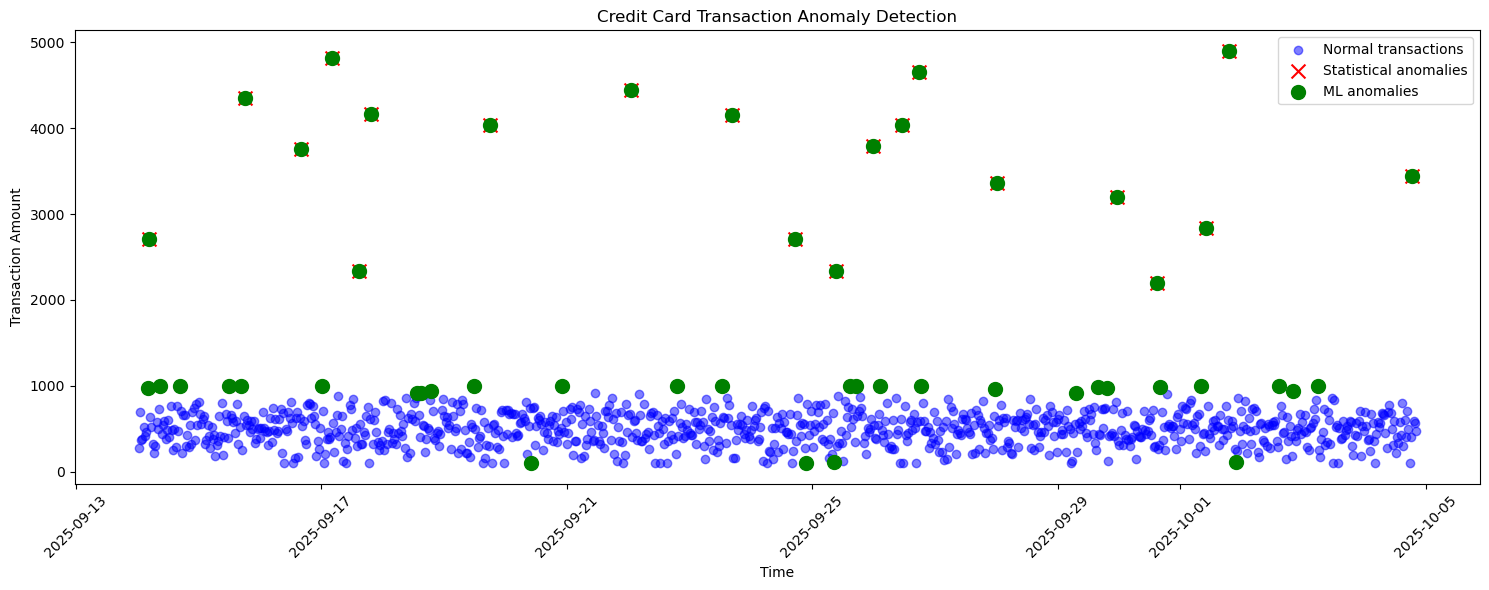

In [1]:
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def generate_sample_data(n_samples=1000):
    """
    生成模拟的信用卡交易数据
    返回: 交易金额和时间
    """
    # 生成正常交易数据 - 大部分金额在100-1000之间
    normal_amounts = np.random.normal(500, 200, n_samples)
    normal_amounts = np.clip(normal_amounts, 100, 1000)
    
    # 添加一些异常值 - 非常大的交易金额
    anomaly_indices = np.random.choice(n_samples, size=int(n_samples * 0.02), replace=False)
    normal_amounts[anomaly_indices] = np.random.uniform(2000, 5000, size=len(anomaly_indices))
    
    # 生成时间序列数据
    base_time = datetime.now()
    times = [base_time + timedelta(minutes=i*30) for i in range(n_samples)]
    
    return normal_amounts, times

def statistical_anomaly_detection(data, threshold=3):
    """
    使用统计方法（Z-score）进行异常检测
    
    参数:
    data: 输入数据
    threshold: 标准差的阈值，超过这个值被认为是异常
    
    返回:
    异常值的索引
    """
    mean = np.mean(data)
    std = np.std(data)
    z_scores = np.abs((data - mean) / std)
    return np.where(z_scores > threshold)[0]

def ml_anomaly_detection(data):
    """
    使用隔离森林进行异常检测
    
    参数:
    data: 输入数据
    
    返回:
    异常值的索引
    """
    # 将数据重塑为二维数组（隔离森林需要二维输入）
    X = data.reshape(-1, 1)
    
    # 创建并训练隔离森林模型
    clf = IsolationForest(contamination=0.05, random_state=42)
    clf.fit(X)
    
    # 预测异常
    predictions = clf.predict(X)
    return np.where(predictions == -1)[0]

def visualize_results(amounts, times, statistical_anomalies, ml_anomalies):
    """
    可视化检测结果
    """
    plt.figure(figsize=(15, 6))
    
    # 绘制所有交易
    plt.scatter(times, amounts, c='blue', alpha=0.5, label='Normal transactions')
    
    # 用红色标记统计方法检测到的异常
    plt.scatter(np.array(times)[statistical_anomalies], 
               amounts[statistical_anomalies], 
               c='red', marker='x', s=100, label='Statistical anomalies')
    
    # 用绿色标记机器学习方法检测到的异常
    plt.scatter(np.array(times)[ml_anomalies], 
               amounts[ml_anomalies], 
               c='green', marker='o', s=100, label='ML anomalies')
    
    plt.title('Credit Card Transaction Anomaly Detection')
    plt.xlabel('Time')
    plt.ylabel('Transaction Amount')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    return plt

# 主程序
if __name__ == "__main__":
    # 生成样本数据
    amounts, times = generate_sample_data()
    
    # 使用统计方法检测异常
    statistical_anomalies = statistical_anomaly_detection(amounts)
    print(f"统计方法检测到 {len(statistical_anomalies)} 个异常")
    
    # 使用机器学习方法检测异常
    ml_anomalies = ml_anomaly_detection(amounts)
    print(f"机器学习方法检测到 {len(ml_anomalies)} 个异常")
    
    # 可视化结果
    plt = visualize_results(amounts, times, statistical_anomalies, ml_anomalies)
    plt.show()

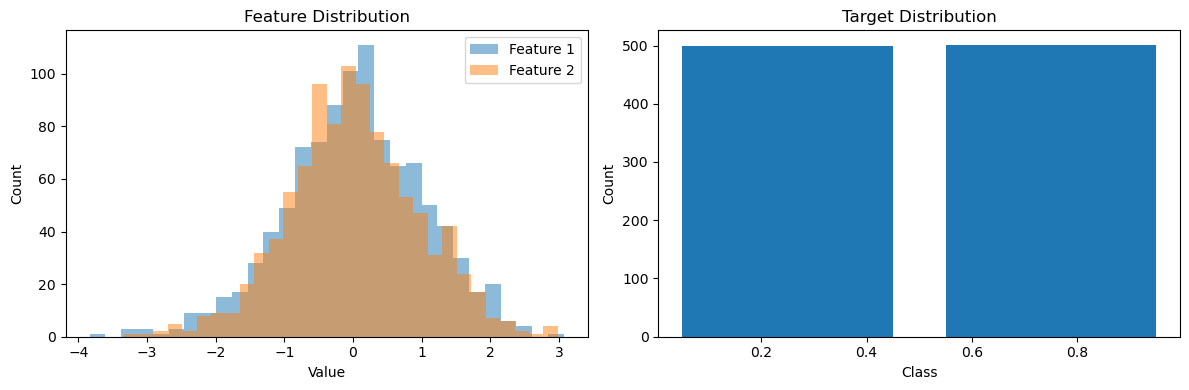

Epoch 1/100


/Users/haoyiwen/miniforge3/envs/machinelearning/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5425 - loss: 0.6867 - val_accuracy: 0.7000 - val_loss: 0.6162
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6913 - loss: 0.5987 - val_accuracy: 0.8050 - val_loss: 0.5326
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8062 - loss: 0.5012 - val_accuracy: 0.8650 - val_loss: 0.4365
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8388 - loss: 0.4196 - val_accuracy: 0.8950 - val_loss: 0.3473
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8737 - loss: 0.3323 - val_accuracy: 0.8900 - val_loss: 0.2787
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8925 - loss: 0.2753 - val_accuracy: 0.8850 - val_loss: 0.2313
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9187 - loss: 0.2215 - val_accuracy: 0.9200 - val_loss: 0.1983
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9325 - loss: 0.1879 - val_accuracy: 0.9450 - val_loss: 0.1

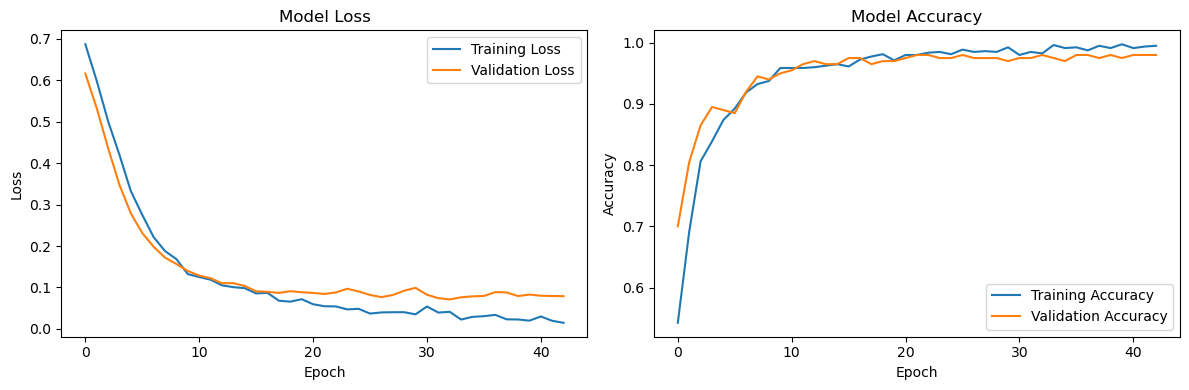


Final Results:
Training Accuracy: 1.0000
Validation Accuracy: 0.9800


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. 生成示例数据
def generate_data(n_samples=1000):
    np.random.seed(42)
    X = np.random.normal(0, 1, (n_samples, 20))
    y = (np.sum(X[:, :5], axis=1) > 0).astype(int)  # 二分类问题
    return X, y

# 2. 创建模型
def create_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# 3. 绘制训练历史
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # 绘制损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # 绘制准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# 4. 训练数据分布可视化
def plot_data_distribution(X, y):
    plt.figure(figsize=(12, 4))
    
    # 绘制特征分布
    plt.subplot(1, 2, 1)
    plt.hist(X[:, 0], bins=30, alpha=0.5, label='Feature 1')
    plt.hist(X[:, 1], bins=30, alpha=0.5, label='Feature 2')
    plt.title('Feature Distribution')
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.legend()
    
    # 绘制目标变量分布
    plt.subplot(1, 2, 2)
    plt.hist(y, bins=2, rwidth=0.8)
    plt.title('Target Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()

# 主程序
def main():
    # 生成数据
    X, y = generate_data()
    
    # 数据可视化
    plot_data_distribution(X, y)
    
    # 数据分割
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # 数据标准化
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # 创建和训练模型
    model = create_model((X_train.shape[1],))
    
    # 添加早停机制
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    # 训练模型并记录历史
    history = model.fit(
        X_train_scaled, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_scaled, y_val),
        callbacks=[early_stopping],
        verbose=1
    )
    
    # 绘制训练历史
    plot_training_history(history)
    
    # 输出最终评估结果
    final_train_loss, final_train_acc = model.evaluate(X_train_scaled, y_train, verbose=0)
    final_val_loss, final_val_acc = model.evaluate(X_val_scaled, y_val, verbose=0)
    
    print("\nFinal Results:")
    print(f"Training Accuracy: {final_train_acc:.4f}")
    print(f"Validation Accuracy: {final_val_acc:.4f}")
    
    return model, history

if __name__ == "__main__":
    model, history = main()